# **Cherry Blossom Data Visualisation**

## Objectives

- Answer business requirement no.1:

  > The client is interested in conducting a study to visually differentiate a healthy cherry leaf from one that contains powdery mildew.

## Inputs

- inputs/cherry-leaves-dataset/test
- inputs/cherry-leaves-dataset/train
- inputs/cherry-leaves-dataset/validation

## Outputs

The notebook will generate the following outputs:

- Computation of the average image size from the train set. This is crucial for training the Convolutional Neural Network (CNN) on the test set, as all input images must have the same size. The input size directly impacts the architecture of the CNN.
- Saving the image shape embeddings as a pickle file.
- Plotting the mean and variability of images per label, providing insights into the distribution of cherry blossom leaves in the dataset.
- Creating a plot that effectively distinguishes between healthy and mildew-infected cherry leaves, aiding in the visual differentiation of these two categories.
- Generating code that addresses business requirement 1 and can be seamlessly integrated into the Streamlit dashboard to create an image montage, enhancing the user experience and facilitating the study of cherry blossom leaves.

---

# Set the working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/kuro/Desktop/PP5 Project/pp5-mildew-detection-in-cherry-leaves/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
work_dir = os.getcwd()
work_dir

'/Users/kuro/Desktop/PP5 Project/pp5-mildew-detection-in-cherry-leaves'

## Set the input directories

The set, train, test and validation paths

In [4]:
my_data_dir = 'inputs/cherry-leaves-dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
test_path = my_data_dir + '/test'
val_path = my_data_dir + '/validation'

## Set the output directory

In [5]:
version = 'v1'
file_path = f'outputs/{version}'

if os.path.exists(os.path.join(work_dir, 'outputs', version)):
    print('Old version is already available. Please create a new version.')
else:
    os.makedirs(file_path)

Old version is already available. Please create a new version.


## Set the label names

In [6]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


---

## Visualising the image data

With the way computers visualise data, it is recommended to normalise image pixel values relative to the dataset mean and standard deviation. This helps to achieve consistent results when applying a model to new images and can also be useful for transfer learning. In practice, computing these statistics can be a little non-trivial since we usually can't load the whole dataset in memory and have to loop through it in batches.

----

## Import the libraries

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import joblib
sns.set_style('white')
from matplotlib.image import imread

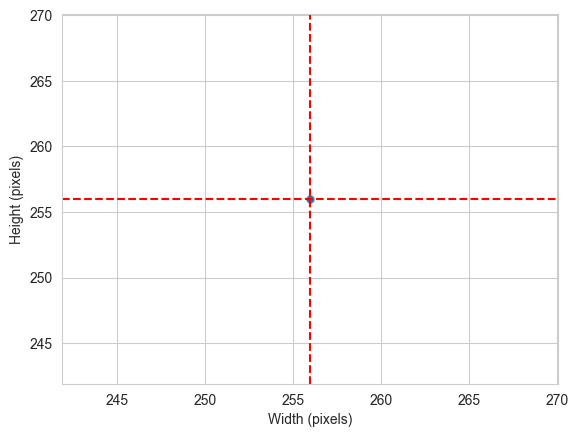

Average Width: 256 pixels
Average Height: 256 pixels


In [22]:
# Initialise empty lists to store dimensions
dim1, dim2 = [], []

# Iterate through each label
for label in labels:
    # Iterate through each image in the train set
    for image_filename in os.listdir(train_path + '/' + label):
        # Read the image and retrieve its dimensions
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        # Append the dimensions to the respective lists
        dim1.append(d1)  # Image height
        dim2.append(d2)  # Image width

# Set the style for the scatter plot
sns.set_style("whitegrid")

# Create subplots and plot the scatter plot
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)

# Set the labels for x-axis and y-axis
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")

# Compute the mean dimensions
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())

# Add vertical and horizontal lines to represent the mean dimensions
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')

# Display the plot
plt.show()

# Print the average width and height dimensions
print(f"Average Width: {dim2_mean} pixels")
print(f"Average Height: {dim1_mean} pixels")

### Image size used for training the model is determined by computing the average dimensions across all images in the train set

In [14]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

### Save the image shape embeddings

In [19]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

## Average and variability of images per label

### Using tensor to create a function that loads the image into an array

In [25]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):
    # Initialise empty arrays for storing images and labels
    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    # Get the list of labels (sub-folders)
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0  # Counter to limit the number of images per label
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # Check if the number of images per label has reached the limit
            if counter < n_images_per_label:
                # Load the image and resize it to the specified size
                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                # Convert the image to array and normalize pixel values if necessary
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                # Append the image array to X and label to y
                X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

### Load the image shapes and labels into an array

In [26]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


### Plot and save the mean and variability of images per label

In [27]:
def plot_mean_variability_per_labels(X, y, figsize=(8, 5), save_image=False):
    """
    The function plots the mean and variability of images for each label in the dataset.
    It loops over all labels, subsets the array for a given label, calculates the mean and standard deviation,
    and creates a figure displaying the mean and variability of images.
    If save_image is True, it saves the image; otherwise, it displays it.
    """

    for label_to_display in np.unique(y):
        # Set the plot style to white
        sns.set_style("white")

        # Reshape y to match the shape of X
        y = y.reshape(-1, 1, 1)

        # Create a boolean mask to filter the array for the current label
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        # Calculate the mean and standard deviation of the array
        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)

        # Print label information
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")

        # Create a figure with two subplots for displaying the mean and variability images
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            # Save the image if save_image is True
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            # Display the image
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


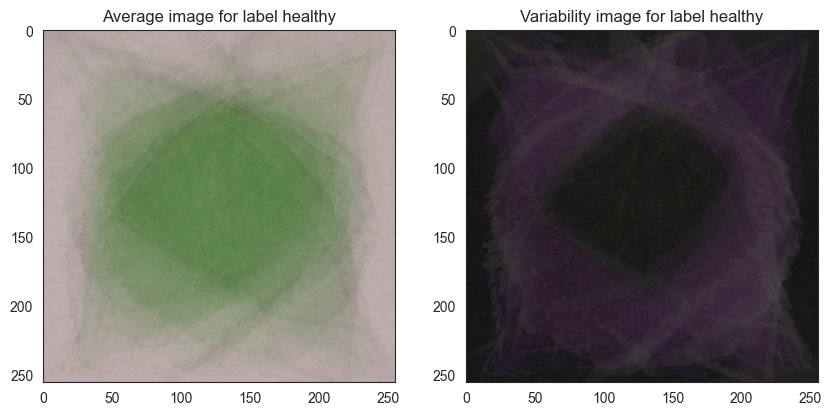

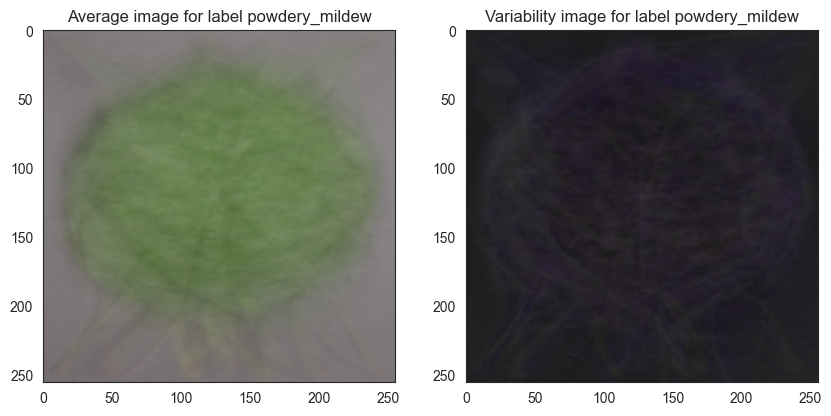

In [28]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(10, 5), save_image=True)

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
